In [1]:
# 使用する(予定の)ライブラリをインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import os
from matplotlib.colors import LogNorm

In [36]:
# シミュレーションに使うクラスの定義
class Plotter:
    def __init__(self):
        self.x_variable = None
        self.y_variable = None
        self.x_data_name = None
        self.y_data_name = None
        self.root_path = None
        self.sovereign_currencies = [
            "Afghanistan","Albania","Australia","Belarus","Brazil","Canada","Chile",
            "Colombia","Czech Republic","Iceland","India","Israel","Japan","Kazakhstan",
            "Kenya","Korea","Malaysia","Mexico","Moldova","Morocco","New Zealand",
            "Pakistan","Paraguay","Peru","Philippines","Poland","Romania","Russia",
            "Singapore","South Africa","Sweden","Thailand","Turkey","United Kingdom",
            "United States",
        ]
        self.common_currencies = [
            "Austria","Belgium","Germany","Spain","France","Greece","Ireland","Italy",
            "Kosovo","Luxembourg","Montenegro","Netherlands","Portugal","Burkina Faso",
            "Senegal","Cameroon","Chad","Equatorial Guinea","Gabon","Republic of Congo",
            "Antigua and Barbuda","St Kitts and Nevis","St Lucia","St Vincent and the Grenadines",
        ]
        self.advanced_nation = [ 
            "Australia","Austria","Belgium","Canada","Czech Republic","Denmark","Finland",
            "France","Germany","Greece","Sweden","Ireland","Italy","Japan","Korea",
            "Luxembourg","Netherlands","New Zealand","Norway","Portugal","Spain",
            "Switzerland","United States","United Kingdom",
        ]

    def search_data_name(self):
        path = self.root_path
        print("0, 国単位の変数")
        print("1, 一人当たりの変数")
        if input("数字を選択して入力:") == "0":
            path += "per_nation/"
        else:
            path += "per_person/"
        print()
        print("1, 成長率")
        print("2, 現地通貨建ての変数")
        print("3, GDP比")
        print("4, GDP比の増加幅")
        print("5, 人口")
        n = input("数字を選択して入力:")
        if n == "1":
            path += "growth_rate/"
        elif n == "2":
            path += "national_currency_variables/"
        elif n == "3":
            path += "per_GDP/"
        elif n == "4":
            path += "diff_rate/"
        else:
            path += "national_currency_variables/人口.csv"
            db = pd.read_csv(path)
            return db, "人口"
        
        files = os.listdir(path)
        for i, file_name in enumerate(files):
            value_name, _ = file_name.split(".")
            print(i+1, ", " + value_name)
        n = int(input("数字を選んで入力:"))
        path += files[n-1]
        db = pd.read_csv(path)
        choosed_data_name, _ = files[n-1].split(".")
        return db, choosed_data_name

    def choose_data(self):
        print("分析対象のデータの種類を選んでください")
        print("１，前年比データを使った分析")
        print("２，2002と2020の比較による分析")
        if input(":") == "1":
            self.root_path = "data/calculated/SingleYear/"
        else:
            self.root_path = "data/calculated/MidleRange/"
        print()
        print("x軸の変数を選んでください")
        x_variable, x_data_name = self.search_data_name()
        print()
        print("y軸の変数を選んでください")
        y_variable, y_data_name = self.search_data_name()
        self.x_variable = x_variable
        self.y_variable = y_variable
        self.x_data_name = x_data_name
        self.y_data_name = y_data_name
        
    def drop_unfilled_countries(self):
        countries_lst = list(set(self.x_variable["Country"]) & set(self.y_variable["Country"]))
        M = min(len(list(self.x_variable.columns)), len(list(self.y_variable.columns)))
        col = ["Country"] + list(self.x_variable.columns)[-M+1:]
        new_x_variable = pd.DataFrame(np.zeros((len(countries_lst), M)), columns=col)
        new_y_variable = pd.DataFrame(np.zeros((len(countries_lst), M)), columns=col)
        new_x_variable["Country"] = countries_lst
        new_y_variable["Country"] = countries_lst
        for i, country in enumerate(countries_lst):
            t = list(self.x_variable[self.x_variable["Country"]==country].values[0])
            new_x_variable.iloc[i,1:] = t[1:]
            t = list(self.y_variable[self.y_variable["Country"]==country].values[0])
            new_y_variable.iloc[i,1:] = t[1:]

        self.x_variable = new_x_variable
        self.y_variable = new_y_variable

    def set_data(self):
        self.choose_data()
        self.drop_unfilled_countries()
        
    def only_advanced_nations(self):
        t = deepcopy(self.advanced_nation)
        first_country = t.pop()
        new_x_db = self.x_variable[self.x_variable["Country"]==first_country].copy()
        new_y_db = self.y_variable[self.y_variable["Country"]==first_country].copy()
        while t:
            country = t.pop()
            new_x_db = pd.concat([new_x_db, self.x_variable[self.x_variable["Country"]==country].copy()])
            new_y_db = pd.concat([new_y_db, self.y_variable[self.y_variable["Country"]==country].copy()])
        new_x_db.sort_values("Country", inplace=True)
        new_y_db.sort_values("Country", inplace=True)
        new_x_db.reset_index(drop=True, inplace=True)
        new_y_db.reset_index(drop=True, inplace=True)
        return new_x_db, new_y_db
    
    def only_developing_country(self):
        t = deepcopy(self.advanced_nation)
        new_x_db = self.x_variable.copy()
        new_y_db = self.y_variable.copy()
        while t:
            country = t.pop()
            new_x_db = new_x_db[new_x_db["Country"]!=country].copy()
            new_y_db = new_y_db[new_y_db["Country"]!=country].copy()
        new_x_db.sort_values("Country", inplace=True)
        new_y_db.sort_values("Country", inplace=True)
        new_x_db.reset_index(drop=True, inplace=True)
        new_y_db.reset_index(drop=True, inplace=True)
        return new_x_db, new_y_db

    def only_sovereign_currencies(self):
        t = deepcopy(self.sovereign_currencies)
        first_country = t.pop()
        new_x_db = self.x_variable[self.x_variable["Country"]==first_country].copy()
        new_y_db = self.y_variable[self.y_variable["Country"]==first_country].copy()
        while t:
            country = t.pop()
            new_x_db = pd.concat([new_x_db, self.x_variable[self.x_variable["Country"]==country].copy()])
            new_y_db = pd.concat([new_y_db, self.y_variable[self.y_variable["Country"]==country].copy()])
        new_x_db.sort_values("Country", inplace=True)
        new_y_db.sort_values("Country", inplace=True)
        new_x_db.reset_index(drop=True, inplace=True)
        new_y_db.reset_index(drop=True, inplace=True)
        return new_x_db, new_y_db
    
    def only_common_currencies(self):
        t = deepcopy(self.common_currencies)
        first_country = t.pop()
        new_x_db = self.x_variable[self.x_variable["Country"]==first_country].copy()
        new_y_db = self.y_variable[self.y_variable["Country"]==first_country].copy()
        while t:
            country = t.pop()
            new_x_db = pd.concat([new_x_db, self.x_variable[self.x_variable["Country"]==country].copy()])
            new_y_db = pd.concat([new_y_db, self.y_variable[self.y_variable["Country"]==country].copy()])
        new_x_db.sort_values("Country", inplace=True)
        new_y_db.sort_values("Country", inplace=True)
        new_x_db.reset_index(drop=True, inplace=True)
        new_y_db.reset_index(drop=True, inplace=True)
        return new_x_db, new_y_db

    def range_scatter(self, xrange=[None, None], yrange=[None, None]):
        print("分析対象の国の種類を選んでください")
        print("0，限定しない")
        print("1，先進国限定")
        print("2，発展途上国限定")
        print("3，変動為替相場制と思われる国限定")
        print("4，共通通貨使用国限定")
        t = input("数字を入力:")
        x_db, y_db, x_arr, y_arr = None, None, None, None
        if t == "0":
            x_db, y_db = self.x_variable, self.y_variable
            x_arr, y_arr = self.x_variable.values, self.y_variable.values
        elif t == "1":
            x_db, y_db = self.only_advanced_nations()
            x_arr, y_arr = x_db.values, y_db.values
        elif t == "2":
            x_db, y_db = self.only_developing_country()
            x_arr, y_arr = x_db.values, y_db.values
        elif t == "3":
            x_db, y_db = self.only_sovereign_currencies()
            x_arr, y_arr = x_db.values, y_db.values
        elif t == "4":
            x_db, y_db = self.only_common_currencies()
            x_arr, y_arr = x_db.values, y_db.values
        
        x_arr = np.array([x_arr[i][1:] for i in range(len(x_db))])
        y_arr = np.array([y_arr[i][1:] for i in range(len(y_db))])
        
        country_lst = list(x_db["Country"])
        country_lst.sort()
        print("対象となった国の一覧")
        for country in country_lst:
            print(country)
        print("******************")

        x_1d, y_1d = x_arr.reshape(len(x_arr)*len(x_arr[0,:])), y_arr.reshape(len(y_arr)*len(y_arr[0,:]))
        
        plt.scatter(x_1d, y_1d)
        plt.xlabel(self.x_data_name + " (%)", fontname="MS Gothic")
        plt.ylabel(self.y_data_name + " (%)", fontname="MS Gothic")
        plt.grid("both")
        plt.xlim(xrange)
        plt.ylim(yrange)
        plt.show()

    def range_hist2d(self, xrange=[None, None], yrange=[None, None], xybins=[100,100], logscale=True):
        # xybinsが、xrangeやyrangeの範囲内で機能していない。要修正
        print("分析対象の国の種類を選んでください")
        print("0，限定しない")
        print("1，先進国限定")
        print("2，発展途上国限定")
        print("3，変動為替相場制と思われる国限定")
        print("4，共通通貨使用国限定")
        t = input("数字を入力:")
        x_db, y_db, x_arr, y_arr = None, None, None, None
        if t == "0":
            x_db, y_db = self.x_variable, self.y_variable
            x_arr, y_arr = self.x_variable.values, self.y_variable.values
        elif t == "1":
            x_db, y_db = self.only_advanced_nations()
            x_arr, y_arr = x_db.values, y_db.values
        elif t == "2":
            x_db, y_db = self.only_developing_country()
            x_arr, y_arr = x_db.values, y_db.values
        elif t == "3":
            x_db, y_db = self.only_sovereign_currencies()
            x_arr, y_arr = x_db.values, y_db.values
        elif t == "4":
            x_db, y_db = self.only_common_currencies()
            x_arr, y_arr = x_db.values, y_db.values
        
        x_arr = np.array([x_arr[i][1:] for i in range(len(x_db))])
        y_arr = np.array([y_arr[i][1:] for i in range(len(y_db))])
        
        country_lst = list(x_db["Country"])
        country_lst.sort()
        print("対象となった国の一覧")
        for country in country_lst:
            print(country)
        print("******************")

        x_1d, y_1d = x_arr.reshape(len(x_arr[:,0])*len(x_arr[0,:])), y_arr.reshape(len(y_arr[:,0])*len(y_arr[0,:]))
        
        if logscale:
            plt.hist2d(x_1d, y_1d, bins=xybins, norm=LogNorm())
        else:
            plt.hist2d(x_1d, y_1d, bins=xybins)
        plt.xlabel(self.x_data_name + " (%)", fontname="MS Gothic")
        plt.ylabel(self.y_data_name + " (%)", fontname="MS Gothic")
        plt.grid("both")
        plt.colorbar()
        plt.xlim(xrange)
        plt.ylim(yrange)
        plt.show()


In [37]:
plotter = Plotter()

In [38]:
plotter.set_data()

分析対象のデータの種類を選んでください
１，前年比データを使った分析
２，2002と2020の比較による分析
:1

x軸の変数を選んでください
0, 国単位の変数
1, 一人当たりの変数
数字を選択して入力:0

1, 成長率
2, 現地通貨建ての変数
3, GDP比
4, GDP比の増加幅
5, 人口
数字を選択して入力:1
1 , GDPデフレータ成長率
2 , インフレ率
3 , 人口成長率
4 , 名目GDP成長率
5 , 名目国内総資本形成成長率
6 , 名目政府の発注がきっかけの総資本形成成長率
7 , 名目政府収入成長率
8 , 名目政府支出成長率
9 , 名目政府最終消費支出成長率
10 , 名目最終消費支出成長率
11 , 名目民間の発注がきっかけの総資本形成成長率
12 , 名目民間付加価値生産額成長率
13 , 名目民間投資支出成長率
14 , 名目民間最終消費支出成長率
15 , 名目輸入成長率
16 , 名目輸出成長率
17 , 実質GDP成長率
18 , 実質国内総資本形成成長率
19 , 実質政府の発注がきっかけの総資本形成成長率
20 , 実質政府収入成長率
21 , 実質政府支出成長率
22 , 実質政府最終消費支出成長率
23 , 実質最終消費支出成長率
24 , 実質民間の発注がきっかけの総資本形成成長率
25 , 実質民間付加価値生産額成長率
26 , 実質民間投資支出成長率
27 , 実質民間最終消費支出成長率
28 , 実質輸入成長率
29 , 実質輸出成長率
数字を選んで入力:8

y軸の変数を選んでください
0, 国単位の変数
1, 一人当たりの変数
数字を選択して入力:0

1, 成長率
2, 現地通貨建ての変数
3, GDP比
4, GDP比の増加幅
5, 人口
数字を選択して入力:1
1 , GDPデフレータ成長率
2 , インフレ率
3 , 人口成長率
4 , 名目GDP成長率
5 , 名目国内総資本形成成長率
6 , 名目政府の発注がきっかけの総資本形成成長率
7 , 名目政府収入成長率
8 , 名目政府支出成長率
9 , 名目政府最終消費支出成長率
10 , 名目最終消費支出成長率
11 , 名目民間の発注がきっかけの総資本形成成長率
12 , 名目民間付加価値生産額成長率
13 , 名目民間投資支出成長

分析対象の国の種類を選んでください
0，限定しない
1，先進国限定
2，発展途上国限定
3，変動為替相場制と思われる国限定
4，共通通貨使用国限定
数字を入力:2
対象となった国の一覧
Afghanistan
Albania
Algeria
Andorra
Angola
Argentina
Aruba
Azerbaijan
Bahrain
Belarus
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Cabo Verde
Cameroon
Chile
China
Colombia
Costa Rica
Croatia
Cyprus
Democratic Republic of the Congo
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Estonia
Eswatini
Ethiopia
Fiji
Gabon
Georgia
Grenada
Guatemala
Guyana
Haiti
Honduras
Hong Kong SAR
Hungary
Iceland
India
Indonesia
Israel
Jamaica
Jordan
Kazakhstan
Kenya
Kiribati
Kosovo
Kuwait
Kyrgyz Republic
Lao PDR
Latvia
Lesotho
Libya
Lithuania
Macao SAR
Malawi
Malaysia
Maldives
Malta
Marshall Islands
Mauritius
Mexico
Moldova
Mongolia
Montenegro
Morocco
Mozambique
Myanmar
Namibia
Nepal
Nicaragua
Niger
Nigeria
North Macedonia
Oman
Pakistan
Palau
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Poland
Qatar
Romania
Russia
Samoa
Sao Tome and Pr

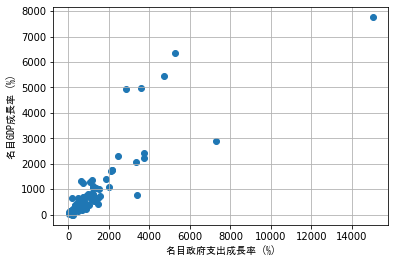

In [32]:
plotter.range_scatter()

分析対象の国の種類を選んでください
0，限定しない
1，先進国限定
2，発展途上国限定
3，変動為替相場制と思われる国限定
4，共通通貨使用国限定
数字を入力:2
対象となった国の一覧
Afghanistan
Albania
Algeria
Andorra
Angola
Argentina
Aruba
Azerbaijan
Bahrain
Belarus
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Cabo Verde
Cameroon
Chile
China
Colombia
Costa Rica
Croatia
Cyprus
Democratic Republic of the Congo
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Estonia
Eswatini
Ethiopia
Fiji
Gabon
Georgia
Grenada
Guatemala
Guyana
Haiti
Honduras
Hong Kong SAR
Hungary
Iceland
India
Indonesia
Israel
Jamaica
Jordan
Kazakhstan
Kenya
Kiribati
Kosovo
Kuwait
Kyrgyz Republic
Lao PDR
Latvia
Lesotho
Libya
Lithuania
Macao SAR
Malawi
Malaysia
Maldives
Malta
Marshall Islands
Mauritius
Mexico
Moldova
Mongolia
Montenegro
Morocco
Mozambique
Myanmar
Namibia
Nepal
Nicaragua
Niger
Nigeria
North Macedonia
Oman
Pakistan
Palau
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Poland
Qatar
Romania
Russia
Samoa
Sao Tome and Pr

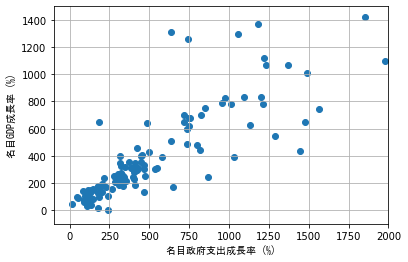

In [33]:
plotter.range_scatter(xrange=[-100,2000], yrange=[-100,1500])

分析対象の国の種類を選んでください
0，限定しない
1，先進国限定
2，発展途上国限定
3，変動為替相場制と思われる国限定
4，共通通貨使用国限定
数字を入力:3
対象となった国の一覧
Afghanistan
Albania
Algeria
Andorra
Angola
Argentina
Aruba
Azerbaijan
Bahrain
Belarus
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Cabo Verde
Cameroon
Chile
China
Colombia
Costa Rica
Croatia
Cyprus
Democratic Republic of the Congo
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Estonia
Eswatini
Ethiopia
Fiji
Gabon
Georgia
Grenada
Guatemala
Guyana
Haiti
Honduras
Hong Kong SAR
Hungary
Iceland
India
Indonesia
Israel
Jamaica
Jordan
Kazakhstan
Kenya
Kiribati
Kosovo
Kuwait
Kyrgyz Republic
Lao PDR
Latvia
Lesotho
Libya
Lithuania
Macao SAR
Malawi
Malaysia
Maldives
Malta
Marshall Islands
Mauritius
Mexico
Moldova
Mongolia
Montenegro
Morocco
Mozambique
Myanmar
Namibia
Nepal
Nicaragua
Niger
Nigeria
North Macedonia
Oman
Pakistan
Palau
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Poland
Qatar
Romania
Russia
Samoa
Sao Tome and Pr

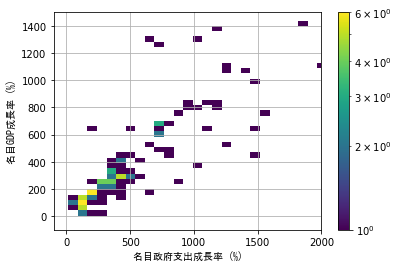

In [35]:
plotter.range_hist2d(xrange=[-100,2000], yrange=[-100,1500], xybins=[200,200])

In [31]:
plotter.set_data()

分析対象のデータの種類を選んでください
１，前年比データを使った分析
２，2002と2020の比較による分析
:1

x軸の変数を選んでください
0, 国単位の変数
1, 一人当たりの変数
数字を選択して入力:1

1, 成長率
2, 現地通貨建ての変数
3, GDP比
4, GDP比の増加幅
5, 人口
数字を選択して入力:1
1 , GDPデフレータ成長率
2 , インフレ率
3 , 人口成長率
4 , 名目GDP成長率
5 , 名目国内総資本形成成長率
6 , 名目政府の発注がきっかけの総資本形成成長率
7 , 名目政府収入成長率
8 , 名目政府支出成長率
9 , 名目政府最終消費支出成長率
10 , 名目最終消費支出成長率
11 , 名目民間の発注がきっかけの総資本形成成長率
12 , 名目民間付加価値生産額成長率
13 , 名目民間投資支出成長率
14 , 名目民間最終消費支出成長率
15 , 名目輸入成長率
16 , 名目輸出成長率
17 , 実質GDP成長率
18 , 実質国内総資本形成成長率
19 , 実質政府の発注がきっかけの総資本形成成長率
20 , 実質政府収入成長率
21 , 実質政府支出成長率
22 , 実質政府最終消費支出成長率
23 , 実質最終消費支出成長率
24 , 実質民間の発注がきっかけの総資本形成成長率
25 , 実質民間付加価値生産額成長率
26 , 実質民間投資支出成長率
27 , 実質民間最終消費支出成長率
28 , 実質輸入成長率
29 , 実質輸出成長率
数字を選んで入力:21

y軸の変数を選んでください
0, 国単位の変数
1, 一人当たりの変数
数字を選択して入力:1

1, 成長率
2, 現地通貨建ての変数
3, GDP比
4, GDP比の増加幅
5, 人口
数字を選択して入力:1
1 , GDPデフレータ成長率
2 , インフレ率
3 , 人口成長率
4 , 名目GDP成長率
5 , 名目国内総資本形成成長率
6 , 名目政府の発注がきっかけの総資本形成成長率
7 , 名目政府収入成長率
8 , 名目政府支出成長率
9 , 名目政府最終消費支出成長率
10 , 名目最終消費支出成長率
11 , 名目民間の発注がきっかけの総資本形成成長率
12 , 名目民間付加価値生産額成長率
13 , 名目民間投資支出成

分析対象の国の種類を選んでください
0，限定しない
1，先進国限定
2，発展途上国限定
3，変動為替相場制と思われる国限定
4，共通通貨使用国限定
数字を入力:0
対象となった国の一覧
Albania
Australia
Austria
Azerbaijan
Belarus
Belgium
Belize
Brunei Darussalam
Bulgaria
Canada
Chile
Colombia
Costa Rica
Croatia
Cyprus
Czech Republic
Democratic Republic of the Congo
Denmark
Ecuador
Egypt
Estonia
Finland
France
Georgia
Germany
Greece
Guatemala
Honduras
Hong Kong SAR
Hungary
Indonesia
Ireland
Israel
Latvia
Lithuania
Luxembourg
Malaysia
Malta
Mexico
Mongolia
Montenegro
Namibia
Netherlands
Nicaragua
North Macedonia
Norway
Pakistan
Paraguay
Philippines
Poland
Portugal
Romania
Saudi Arabia
Serbia
Slovak Republic
Slovenia
South Africa
Spain
Sri Lanka
Sweden
Thailand
Togo
Uganda
Ukraine
Uzbekistan
******************


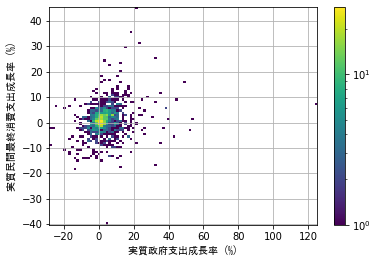

In [32]:
plotter.range_hist2d()

分析対象の国の種類を選んでください
0，限定しない
1，先進国限定
2，発展途上国限定
3，変動為替相場制と思われる国限定
4，共通通貨使用国限定
数字を入力:1
対象となった国の一覧
Australia
Austria
Belgium
Canada
Czech Republic
Denmark
Finland
France
Germany
Greece
Ireland
Luxembourg
Netherlands
Norway
Portugal
Spain
Sweden
******************


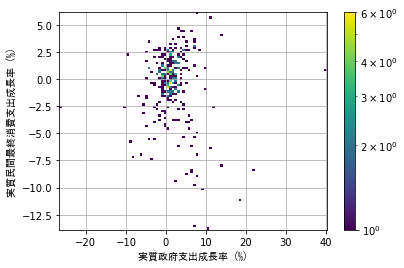

In [33]:
plotter.range_hist2d()